In [1]:
# Imports
import Transformer
from tensorflow.keras.optimizers import Adam

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, LastDimensionNormalizer, Batcher
from Quaternion_functions import MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
from Quaternion_functions import quaternion_to_euler_angle_vectorized1
from Quaternion_functions import qprod, pointprod
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

import ahrs

In [2]:
folder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható

# load in the full measurement sequence
d = DataStream(folder)

# Slice the second part for Calibration
d_calib = deepcopy(d)
d_calib.keepData(2600, 18500)

# Calibrate the rest of the measurement (Training, Validation and Test set also)
d.calibrateMag(d_calib)

# Add extra features to the collective database here
#d.addFeature(['diff_Timestamp']) #it can be changed, to the orginal timstamp:
d.addFeature(['Timestamp'])
d.addFeature(['MARG_quatW'])
d.addFeature(['MARG_quatX']) 
d.addFeature(['MARG_quatY'])
d.addFeature(['MARG_quatZ']) 

# Apply filter for the rest of the measurement (Training, Validation and Test set also)
d.filterData(31, 'bartlett', [1, 2, 3]) # filter Acc
d.filterData(31, 'bartlett', [4, 5, 6]) # filter Gyro
d.filterData(31, 'bartlett', [7, 8, 9]) # filter Mag

# Slice the first part for Initialization (Calculate the Rotation Qoaternion betwwen MoCap and Sensor coordinate system)
d_stand = deepcopy(d)
d_stand.keepData(0,500)

d.calibMadgwick(d_stand, axis='MOC')
'''
TODO: why axis parameter? Jobb név kéne, "base" esetleg
'''
# Slice the third part of the measurement for Training dataset
d_train = deepcopy(d)
d_train.keepData(18600, 42100)
d_train.calcMadgwick()
# If further filtering is needed apply here for only on Training data

# Slice the fourth part of the measurement for Validation dataset
d_valid = deepcopy(d)
d_valid.keepData(43000, 51000)
d_valid.calcMadgwick()
# If further filtering is needed apply here for only on Validation data

# Slice the fifth part of the measurement for Test dataset
d_test = deepcopy(d)
d_test.keepData(51500, 61720)
d_test.calcMadgwick() 
# If further filtering is needed apply here for only on Test data

In [3]:
d_test.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatW
14 - MARG_quatX
15 - MARG_quatY
16 - MARG_quatZ
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - Timestamp
21 - MARG_quatW
22 - MARG_quatX
23 - MARG_quatY
24 - MARG_quatZ
25 - Madgwick_W
26 - Madgwick_X
27 - Madgwick_Y
28 - Madgwick_Z


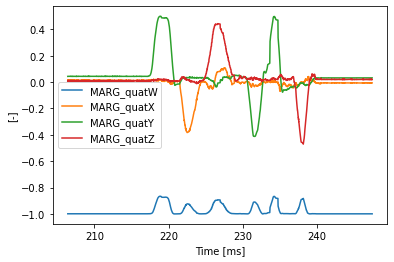

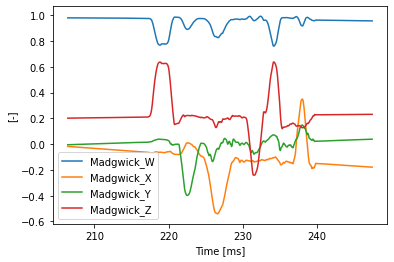

In [4]:
d_test.plotData(cols=[13,14,15,16]) # original Mocap
d_test.plotData(cols=[25,26,27,28]) # original Madgwick

In [5]:
# Coorrdinate system correction
#mocapToMadgwick() or madgwickToMocap()
d_train.mocapToMadgwick([21,22,23,24])
d_valid.mocapToMadgwick([21,22,23,24])
d_test.mocapToMadgwick([21,22,23,24]) # Mocap transferd to Madgwick koordinate system

In [6]:
# turning the training madgwick data, for tha training to work:
d_train.data[:,21:25] = d_train.data[:,21:25]*-1

#changing the times:
d_train.data[:,20] = d_train.data[:,20] - d_train.data[0,20]
d_valid.data[:,20] = d_valid.data[:,20] - d_valid.data[0,20]
d_test.data[:,20] = d_test.data[:,20] - d_test.data[0,20]

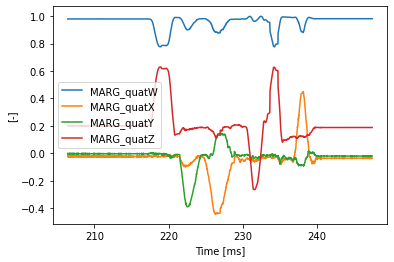

In [7]:
d_test.plotData(cols=[21,22,23,24]) # Mocap transferd to Madgwick koordinate system

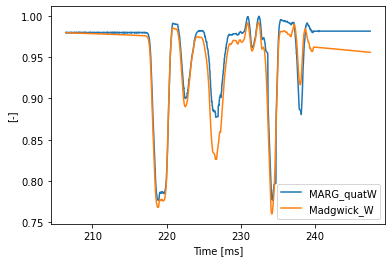

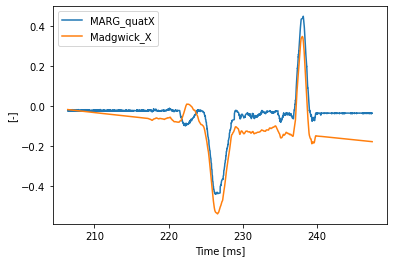

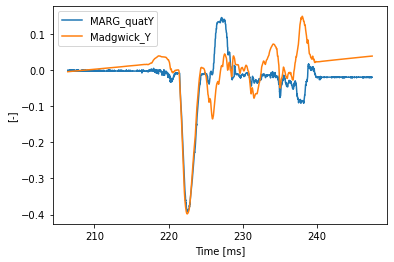

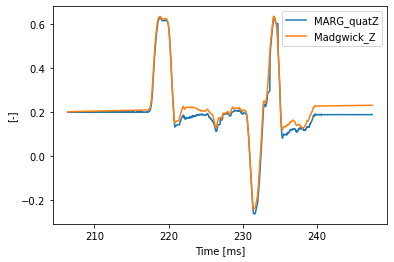

In [8]:
d_test.plotData(cols=[21,25])
d_test.plotData(cols=[22,26])
d_test.plotData(cols=[23,27])
d_test.plotData(cols=[24,28])

In [9]:
d_test.calibMadgwick(d_stand, axis='MOC', plot_distance = True)

## Transformer network parameters

In [10]:
# Actual input and label data for the training. The columns defined in data_const will be constat in each sequence (first value)
data = [20,1,2,3,4,5,6,7,8,9,25,26,27,28]
# 0 - real time kéne méréshez igazítva
data_const=[]

label = [21,22,23,24] # MoCapet jósol

# Define parameters of the Transformer network
num_layers = 10
d_model = 16
dff = 32
num_heads = 16   # d_model / num_heads should be integer
kernel_size = 5
input_size = len(data)
target_size = len(label)
dropout_rate = 0.1

enc_local = 4 #exponenciális dilatáció
enc_repetitions = 2 # (in_seq_len  - enc_local) / enc_repetioin = should be integer  #eponenciális dilatáció száma
dec_local = 2
dec_repetitions = 1 # (tar_seq_len - dec_local) / dec_repetioin = should be integer

in_seq_len = 8
tar_seq_len = 4

batch_size = 32

epochs = 5


## Data preparation for Transformer network

In [11]:
# Parsing the data 
# =============Training data========================
X_alap, X_header, _, _ = d_train.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap, Y_header = d_train.dataParser([], label, tar_seq_len)
Y_alap = Y_alap[in_seq_len-tar_seq_len:,:,:]

nx = LastDimensionNormalizer()
ny = LastDimensionNormalizer()

X_norm = nx.normalize(X_alap)
Y_norm = ny.normalize(Y_alap)

# Batching the data
batcher = Batcher(batch_size, shuffle=True)
X_train = batcher.batch(X_norm)
Y_train = batcher.batch(Y_norm)

# Dimension check
print('d_train.data: ', d_train.data.shape)
print('X_alap:   ', X_alap.shape, '   Y_alap: ', Y_alap.shape)
print('X_norm:   ', X_norm.shape, '   Y_norm: ', Y_norm.shape)
print('X_train:  ', X_train.shape,' Y_train:', Y_train.shape)

# ==================Test data=====================
X_alap_T, X_header_T,_,_ = d_test.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap_T, Y_header_T = d_test.dataParser([], label, tar_seq_len)
Y_alap_T = Y_alap_T[in_seq_len-tar_seq_len:,:,:]

#nx = Normalizer()
#ny = Normalizer()

X_norm_T = nx.normalize(X_alap_T)
Y_norm_T = ny.normalize(Y_alap_T)

batcher = Batcher(batch_size, shuffle=True)

X_test = batcher.batch(X_norm_T)
Y_test = batcher.batch(Y_norm_T)

# Dimension check
print('d_test.data: ', d_test.data.shape)
print('X_alap:   ', X_alap_T.shape, '   Y_alap: ', Y_alap_T.shape)
print('X_norm:   ', X_norm_T.shape, '   Y_norm: ', Y_norm_T.shape)
print('X_test:   ', X_test.shape,   ' Y_test: ', Y_test.shape)


d_train.data:  (23500, 29)
X_alap:    (23493, 8, 14)    Y_alap:  (23493, 4, 4)
X_norm:    (23493, 8, 14)    Y_norm:  (23493, 4, 4)
X_train:   (734, 32, 8, 14)  Y_train: (734, 32, 4, 4)
d_test.data:  (10220, 29)
X_alap:    (10213, 8, 14)    Y_alap:  (10213, 4, 4)
X_norm:    (10213, 8, 14)    Y_norm:  (10213, 4, 4)
X_test:    (319, 32, 8, 14)  Y_test:  (319, 32, 4, 4)


## Transformer network setup and train

In [12]:
# Define loss function for the Transformer network
def loss_function(real, pred):
    return tf.reduce_mean(tf.math.square(real-pred))

In [13]:
# Set up the Transformer network
output_size = Y_train.shape[-1]

trans = Transformer.Transformer(num_layers, d_model, kernel_size, num_heads, dff, input_size, target_size, output_size, in_seq_len, tar_seq_len-1, rate=dropout_rate)
trans.setEncoderLogsparseMasks(enc_local,enc_repetitions)
trans.setDecoderLogsparseMasks(dec_local,dec_repetitions)
trans.setLoss(loss_function)
trans.setOptimizer(Adam())

In [14]:
# Epoch number and Training
trans.train(epochs, X_train, Y_train[:,:,:-1,:], Y_train[:,:,-1,:], shuffle=True)

Epoch 1 Train Loss 0.0776842
Time taken for 1 epoch: 127.61665177345276 secs

Epoch 2 Train Loss 0.0252074
Time taken for 1 epoch: 76.89975333213806 secs

Epoch 3 Train Loss 0.0094476
Time taken for 1 epoch: 76.60181999206543 secs

Epoch 4 Train Loss 0.0056232
Time taken for 1 epoch: 75.92727971076965 secs

Epoch 5 Train Loss 0.0041860
Time taken for 1 epoch: 75.64283657073975 secs



# Prediction

In [15]:
sid = 3000
eid = 4500
# Predict on dependent trainig data
pred_onTrain = trans.predict_structured(X_norm[sid:eid,...],Y_norm[sid:eid,:-1,:])

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


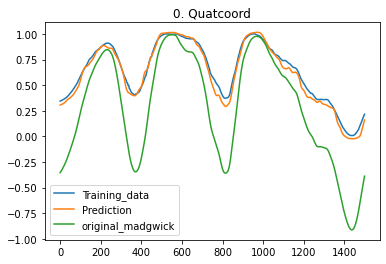

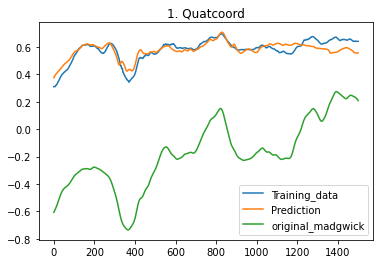

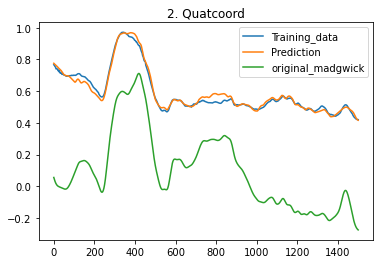

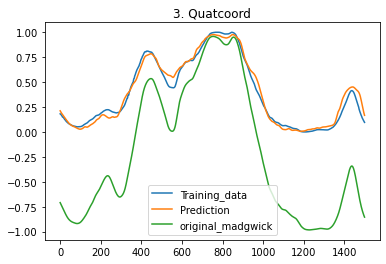

In [18]:
# plot on Train
# Plot in normalised space on training data (if it fits it possibly means OverFitting)
for i in range(4):
    plt.figure(i)
    plt.title(str(i)+". Quatcoord")
    plt.plot(Y_norm[sid:eid,-1,i], label='Training_data')     # dependent training data
    plt.plot(pred_onTrain[:,i], label='Prediction')
    plt.plot(d_train.data[3000:4500, 25+i], label='original_madgwick')
    plt.legend()

plt.show()

# Dernormalization

In [19]:
sid = 3000
eid = 4500
# Predict on dependent training data
pred_onTest = trans.predict_structured(X_norm_T[sid:eid,...],Y_norm_T[:,:-1,:])

Y_denorm_T = ny.denormalize(Y_norm_T)
denorm_pred_onTest = ny.denormalize(pred_onTest)

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


# Plot

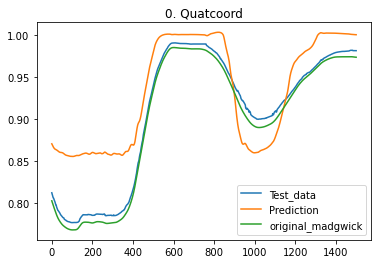

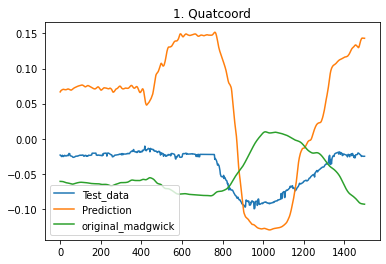

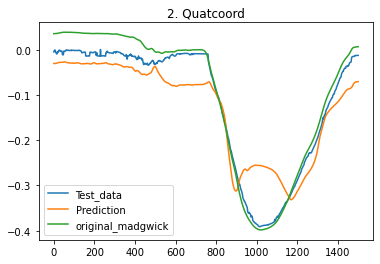

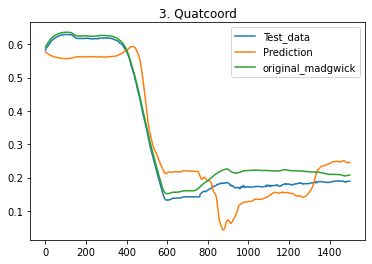

In [21]:
# Plot in normalized space with Madgwick. If it fits it means a good trainig.
for i in range(4):
    plt.figure(i)
    plt.title(str(i)+". Quatcoord")
    plt.plot(Y_denorm_T[sid:eid,-1,i], label='Test_data') # Independent test data
    plt.plot(denorm_pred_onTest[:,i], label='Prediction')
    plt.plot(d_test.data[3000:4500, 25+i], label='original_madgwick')
    #plt.plot(d_test.madgwick[sid:eid,i], label='Madgwick')
    plt.legend()
plt.show()